# FrozenLake [8x8 | no random map | on slip]

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo


plt.style.use('dark_background')

# seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Pytorch device:", device)

Pytorch device: cuda


### Model

In [38]:
class FrozenLake8x8V0(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=512):
        super(FrozenLake8x8V0, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        return self.network(x)

## Replay Buffer

In [23]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## Agent

In [24]:
class DQNAgent:
    def __init__(self, modelClass, state_size, action_size, lr=1e-3, gamma=0.99,
                 buffer_size=10000, batch_size=64, target_update=100):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update = target_update

        # Q-network and target network
        self.q_net = modelClass(state_size, action_size).to(device)
        self.target_net = modelClass(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        # Sync target network
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.memory = ReplayBuffer(buffer_size)
        self.step_count = 0

    def act(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.q_net(state)
        return q_values.argmax().item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        # sample batch
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)

        # current q-values
        current_q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # next q-values frm target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))

        # compute loss
        loss = nn.MSELoss()(current_q_values, target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network periodically
        self.step_count += 1
        if self.step_count % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


## Training Loop

In [41]:
def create_env():
    env = gym.make("FrozenLake8x8-v1",
                   is_slippery=False,
                   render_mode=None)
    state_size = env.observation_space.n
    action_size = env.action_space.n  # 4 (left, down, right, up)

    return env, state_size, action_size


def one_hot_state(s, size):
    vec = np.zeros(size)
    vec[s] = 1.0
    return vec


def train_dqn(agent, env, state_size, action_size, episodes=2000, max_steps=100):
    scores = deque(maxlen=100)  # for moving average
    epsilon_start = 0.900
    epsilon_end   = 0.010
    epsilon_decay = 0.999

    epsilon = epsilon_start

    # Track metrics for plotting
    avg_rewards = []
    epsilons = []

    print("Starting training...")
    for episode in range(episodes):
        state, _ = env.reset()
        state = one_hot_state(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # FrozenLake gives sparse reward: 1 only if goal reached
            reward = reward - 0.01  # optional shaping to encourage speed

            next_state = one_hot_state(next_state, state_size)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

            state = next_state
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Log every episode for smooth plot
        avg_score = np.mean(scores)
        avg_rewards.append(avg_score)
        epsilons.append(epsilon)

        if episode % 100 == 0:
            avg_score = np.mean(scores)
            print(f"Episode {episode}, Avg Reward (last 100): {avg_score:.3f}, Epsilon: {epsilon:.3f}")

    return agent, env, (avg_rewards, epsilons)


def evaluate_agent(agent, env, episodes=10, max_steps=100):
    state_size = env.observation_space.n

    success = 0
    for _ in range(episodes):
        state, _ = env.reset()
        state = one_hot_state(state, state_size)
        for _ in range(max_steps):
            action = agent.act(state, epsilon=0.0)  # greedy
            state, reward, terminated, truncated, _ = env.step(action)
            state = one_hot_state(state, state_size)
            if terminated or truncated:
                if reward == 1.0:
                    success += 1
                break
    print(f"\nSuccess rate over {episodes} episodes: {success}/{episodes} ({100 * success / episodes:.1f}%)")

In [46]:
env, state_size, action_size = create_env()
agent = DQNAgent(modelClass=FrozenLake8x8V0,
                 state_size=state_size,
                 action_size=action_size,
                 lr=1e-4,
                 gamma=0.9,
                 buffer_size=20_000,
                 batch_size=64,
                 target_update=50)

Starting training...
Episode 0, Avg Reward (last 100): 0.000, Epsilon: 0.895
Episode 100, Avg Reward (last 100): 0.000, Epsilon: 0.542
Episode 200, Avg Reward (last 100): 0.050, Epsilon: 0.329
Episode 300, Avg Reward (last 100): 0.590, Epsilon: 0.199
Episode 400, Avg Reward (last 100): 0.780, Epsilon: 0.121
Episode 500, Avg Reward (last 100): 0.770, Epsilon: 0.073
Episode 600, Avg Reward (last 100): 0.850, Epsilon: 0.044
Episode 700, Avg Reward (last 100): 0.930, Epsilon: 0.027
Episode 800, Avg Reward (last 100): 0.940, Epsilon: 0.016
Episode 900, Avg Reward (last 100): 0.970, Epsilon: 0.010
Episode 1000, Avg Reward (last 100): 0.990, Epsilon: 0.010
Episode 1100, Avg Reward (last 100): 0.980, Epsilon: 0.010
Episode 1200, Avg Reward (last 100): 0.980, Epsilon: 0.010
Episode 1300, Avg Reward (last 100): 0.980, Epsilon: 0.010
Episode 1400, Avg Reward (last 100): 0.980, Epsilon: 0.010
Episode 1500, Avg Reward (last 100): 0.950, Epsilon: 0.010
Episode 1600, Avg Reward (last 100): 0.970, Eps

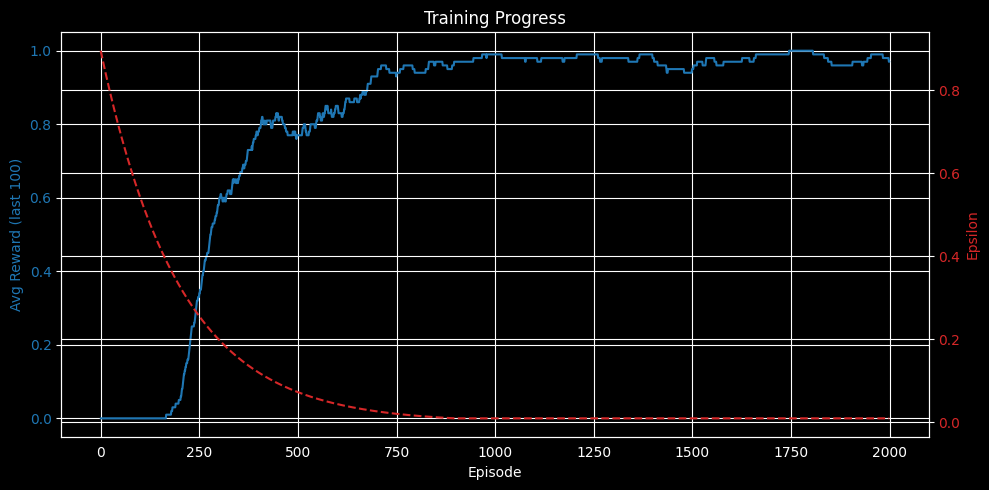

In [47]:
agent, env, (avg_rewards, epsilons) = train_dqn(
    agent=agent,
    env=env,
    state_size=state_size,
    action_size=action_size,
    episodes=2_000,
    max_steps=300)

# Plotting
print(f"\\nModel: {FrozenLake8x8V0.__name__}", agent.q_net)
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Episode')
ax1.set_ylabel('Avg Reward (last 100)', color=color)
ax1.plot(avg_rewards, color=color, label='Avg Reward')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Epsilon', color=color)
ax2.plot(epsilons, color=color, label='Epsilon', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Training Progress')
fig.tight_layout()
plt.show()

In [ ]:
# env.close()

In [48]:
eval_env = gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode="human")
evaluate_agent(agent, eval_env, episodes=2)
eval_env.close()


Success rate over 2 episodes: 2/2 (100.0%)


In [51]:
# Create environment wrapped with video recorder
eval_env = RecordVideo(
    gym.make("FrozenLake8x8-v1", is_slippery=False, render_mode="rgb_array"),
    video_folder="files",               # Directory to save videos
    name_prefix="frozenlake_8x8",       # Prefix for video filename
    episode_trigger=lambda x: True       # Record every episode (x = episode index)
)

# Run evaluation (must use render_mode="rgb_array" for video)
evaluate_agent(agent, eval_env, episodes=1)

# Close to finalize video writing
eval_env.close()
# ffmpeg -i input.mp4 -vf "fps=10,scale=320:-1:flags=lanczos" -loop 0 output.gif

/home/ezio4df/projects/play-FrozenLake/.venv/lib/python3.13/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/ezio4df/projects/play-FrozenLake/files folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Success rate over 1 episodes: 1/1 (100.0%)
